# Evaluation for trained model to decode 32 bits polar code 

In [1]:
import sys, pathlib, pandas as pd
import json
import re, matplotlib.pyplot as plt, os

p = pathlib.Path.cwd()
while p != p.parent:
    if (p / "models").exists():
        project_root = p
        break
    p = p.parent

sys.path.insert(0, str(project_root))

In [2]:
import torch
from dataset import PolarDecDataset 
from models.wrappers.mamba_32bits import MambaPolarDecoder

from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/aayush/Desktop/5G-Polar/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [3]:
N = 32

In [4]:
ckpt_path = "../checkpoints/config_33/model_best_block_epoch_5_snr_10.pt" 



In [5]:
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
ckpt

{'comments': 'Removed the snr as input entirely. Use SNR linear if needed.',
 'model_config': {'d_model': 64,
  'num_layer_encoder': 1,
  'num_layers_bimamba_block': 12,
  'seq_len': 32,
  'd_state': 32,
  'd_conv': 6,
  'expand': 2},
 'epoch': 5,
 'train_loss': 0.07294789338111878,
 'val_loss': np.float64(0.15247395833333333),
 'state_dict': OrderedDict([('residual_scale',
               tensor(1.1790, device='cuda:0')),
              ('discrete_embedding.weight',
               tensor([[-0.1951, -0.1485,  0.1792, -0.1095, -0.1333,  0.1941,  0.1265,  0.1859,
                        -0.1774, -0.1446, -0.1785, -0.1892, -0.1120,  0.1405,  0.1835,  0.1611,
                         0.1716, -0.1337, -0.1816,  0.1734,  0.0843,  0.1764, -0.1273,  0.1906,
                        -0.0773,  0.1817, -0.0091,  0.1100, -0.1823, -0.1380, -0.1493,  0.1240,
                        -0.1637,  0.1619, -0.1733,  0.1620,  0.1564, -0.1824,  0.1441,  0.1830,
                        -0.1103, -0.1930, -0.1795,

In [ ]:
model = MambaPolarDecoder(
    d_model=ckpt['model_config']['d_model'],
    num_layer_encoder=ckpt['model_config']['num_layer_encoder'],
    num_layers_bimamba_block=ckpt['model_config']['num_layers_bimamba_block'],
    seq_len=ckpt['model_config']['seq_len'],
    d_state=ckpt['model_config']['d_state'],
    d_conv=ckpt['model_config']['d_conv'],
    expand=ckpt['model_config']['expand']
).to(device)
model

MambaPolarDecoder(
  (discrete_embedding): Embedding(2, 64)
  (linear_embedding1): Linear(in_features=1, out_features=64, bias=True)
  (input_layer): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (encoder_layers): ModuleList(
    (0): BiMambaEncoder(
      (layers): ModuleList(
        (0-11): 12 x BiMambaBlock(
          (pre_ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mamba_f): Mamba(
            (in_proj): Linear(in_features=64, out_features=256, bias=False)
            (conv1d): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(5,), groups=128)
            (act): SiLU()
            (x_proj): Linear(in_features=128, out_features=68, bias=False)
            (dt_proj): Linear(in_features=4, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=64, bias=False)
          )
          (post_ln_f

### Metrics

In [ ]:


# load model
state_dict = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [8]:
import json
import torch
from torch.utils.data import DataLoader

def calc_save_ber(
    model,
    device,
    msg_bit_sizes: list,
    snr_db: list,
    num_samples=32000,
    batch_size=32,
    json_file_name=None,
):
    """
    Calculate BER over a test dataset and save detailed BER stats
    for message and frozen bits.
    """

    eval_results = {}

    for each_snr_val in snr_db:
        print(f"\nEvaluating for SNR = {each_snr_val} dB\n")

        snr_key = f"{each_snr_val}_snr"
        eval_results[snr_key] = {}
        ber_list = []

        for each_msg_bit_size in msg_bit_sizes:
            print(f"  Message bit size = {each_msg_bit_size}")

            total_msg_bit_errors = 0
            total_frozen_bit_errors = 0
            total_msg_bits = 0
            total_frozen_bits = 0

            
            test_set = PolarDecDataset(
                snr_list=[each_snr_val],      
                num_samples=num_samples,
                fixed_msg_bit_size=each_msg_bit_size,
                seq_length=32,
            )

            test_loader = DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,
            )

            model.eval()
            with torch.no_grad():
                for llrs, frozen_tensor, snr_tensor, target_tensor in test_loader:

                    llrs = llrs.to(device).float()
                    frozen_tensor = frozen_tensor.to(device).long()
                    target_tensor = target_tensor.to(device).long()

                    # forward pass
                    logits = model(llrs, frozen_tensor, snr_tensor.to(device))

                    # hard decision
                    predicted = (logits > 0).long()

                    # masks
                    mask_msg = (frozen_tensor == 1)
                    mask_frozen = (frozen_tensor == 0)

                    msg_target = target_tensor[mask_msg]
                    msg_pred = predicted[mask_msg]

                    frozen_target = target_tensor[mask_frozen]
                    frozen_pred = predicted[mask_frozen]

                    total_msg_bit_errors += (msg_target != msg_pred).sum().item()
                    total_frozen_bit_errors += (frozen_target != frozen_pred).sum().item()

                    total_msg_bits += msg_target.numel()
                    total_frozen_bits += frozen_target.numel()

            total_bits = total_msg_bits + total_frozen_bits
            total_error_bits = total_msg_bit_errors + total_frozen_bit_errors

            avg_net_ber = total_error_bits / total_bits
            avg_msg_ber = total_msg_bit_errors / total_msg_bits if total_msg_bits > 0 else 0.0
            avg_frozen_ber = (
                total_frozen_bit_errors / total_frozen_bits if total_frozen_bits > 0 else 0.0
            )

            print(f"    Net BER     : {avg_net_ber:.6e}")
            print(f"    Msg BER     : {avg_msg_ber:.6e}")
            print(f"    Frozen BER  : {avg_frozen_ber:.6e}\n")

            ber_list.append(avg_net_ber)

            eval_results[snr_key][str(each_msg_bit_size)] = {
                "average_net_bit_error_rate": avg_net_ber,
                "average_msg_bit_error_rate": avg_msg_ber,
                "average_frozen_bit_error_rate": avg_frozen_ber,
                "batch_size": batch_size,
                "num_samples": num_samples,
                "total_bits": total_bits,
                "total_error_bits": total_error_bits,
                "total_msg_bits": total_msg_bits,
                "total_frozen_bits": total_frozen_bits,
            }

        eval_results[snr_key]["overall_ber"] = sum(ber_list) / len(ber_list)

    if json_file_name:
        with open(f"{json_file_name}.json", "w") as f:
            json.dump(eval_results, f, indent=4)
        print(f"Results saved to {json_file_name}.json")

    return eval_results


In [9]:
calc_save_ber(model, device, msg_bit_sizes=[8, 16,24], snr_db=[10], json_file_name="checkk")



Evaluating for SNR = 10 dB

  Message bit size = 8
    Net BER     : 9.728516e-03
    Msg BER     : 3.020703e-02
    Frozen BER  : 2.902344e-03

  Message bit size = 16
    Net BER     : 1.674219e-02
    Msg BER     : 3.339258e-02
    Frozen BER  : 9.179688e-05

  Message bit size = 24
    Net BER     : 4.711914e-02
    Msg BER     : 6.281510e-02
    Frozen BER  : 3.125000e-05

Results saved to checkk.json


{'10_snr': {'8': {'average_net_bit_error_rate': 0.009728515625,
   'average_msg_bit_error_rate': 0.03020703125,
   'average_frozen_bit_error_rate': 0.00290234375,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 9962,
   'total_msg_bits': 256000,
   'total_frozen_bits': 768000},
  '16': {'average_net_bit_error_rate': 0.0167421875,
   'average_msg_bit_error_rate': 0.033392578125,
   'average_frozen_bit_error_rate': 9.1796875e-05,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 17144,
   'total_msg_bits': 512000,
   'total_frozen_bits': 512000},
  '24': {'average_net_bit_error_rate': 0.047119140625,
   'average_msg_bit_error_rate': 0.06281510416666666,
   'average_frozen_bit_error_rate': 3.125e-05,
   'batch_size': 32,
   'num_samples': 32000,
   'total_bits': 1024000,
   'total_error_bits': 48250,
   'total_msg_bits': 768000,
   'total_frozen_bits': 256000},
  'overall_ber': 0.024529947916666666

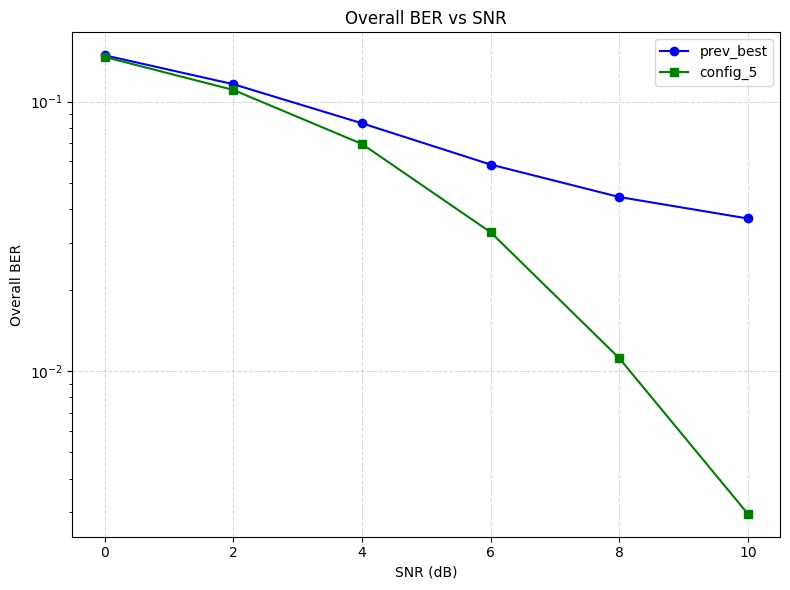

In [1]:
import os
import json
import matplotlib.pyplot as plt

# --- JSON filenames ---
model_files = {
    "prev_best": "evaluation_model_config_13_CL_trained_-10.json",
    # "latest": "config35_trained_on_biblock_16.json",
    # "config_4": "config_4_biblock20.json",
    "config_5": "config_5_biblock20_all_minute_levels.json"
}

# --- Load all eval results ---
eval_results = {}
for model_name, file_name in model_files.items():
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"{file_name} not found in current directory")
    with open(file_name, 'r') as f:
        eval_results[model_name] = json.load(f)

# --- Define SNR range explicitly: 10 → -10 (step -2) ---
snrs = list(range(10, -2, -2))   # [10, 8, 6, 4, 2, 0, -2, -4, -6, -8, -10]

# --- Prepare BER values ---
ber_values = {}
for model_name, results in eval_results.items():
    ber_values[model_name] = [
        results[f"{snr}_snr"]["overall_ber"] for snr in snrs
    ]

# --- Plot ---
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for (model_name, ber), color, marker in zip(ber_values.items(), colors, markers):
    plt.plot(
        snrs,
        ber,
        marker=marker,
        color=color,
        label=model_name
    )

plt.xlabel("SNR (dB)")
plt.ylabel("Overall BER")
plt.title("Overall BER vs SNR")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(snrs)
plt.yscale("log")
plt.tight_layout()
plt.show()
